In [2]:
import pandas as pd
import matplotlib as plt
import numpy as np
from fuzzywuzzy import process

In [3]:
df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

df = df[df["Data_Value_Type"].str.contains("Crude", na=False)]


# Rename the city column
df = df.rename(columns={"LocationName": "city"})


# Drop unnecessary columns
df = df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'TotalPopulation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)
# First, let's identify the unique cities and measures
unique_cities = df['city'].unique()
unique_measures = df['Short_Question_Text'].unique()

print(f"Number of unique cities: {len(unique_cities)}")
print(f"Number of unique measures: {len(unique_measures)}")

# Create a pivot table with cities as index and measures as columns
new_df = df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

# Reset the index to make 'city' a column again
new_df = new_df.reset_index()

new_df = new_df.drop(['Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
 'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
 'Mammography use among women aged 50-74 years',
 'Cholesterol screening among adults aged >=18 years',
 'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
 'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
], axis=1)

# All diseases
# list(df['Measure'].unique())


df.head()



Number of unique cities: 1841
Number of unique measures: 30


,Year,city,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Short_Question_Text
0,2020,NaN,Current lack of health insurance among adults ...,%,Crude prevalence,15.3,Health Insurance
1,2020,Talladega,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,15.1,Diabetes
2,2020,Tallapoosa,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,16.0,Diabetes
4,2020,Aleutians East,Cervical cancer screening among adult women ag...,%,Crude prevalence,68.3,Cervical Cancer Screening
5,2020,Anchorage,Depression among adults aged >=18 years,%,Crude prevalence,16.5,Depression


In [4]:
airdf = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")


# Filter by US
airdf = airdf[airdf["country_name"] == "United States of America"]

# Drop unnnecessary columns
airdf = airdf.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
airdf['city'] = airdf['city'].str.split(' ').str[0]

# Leave only year 2020
airdf = airdf[airdf['year'] == 2019.0]


In [5]:
def find_best_match_city(city, citylist, threshold=80):
    best_match, score = process.extractOne(city, citylist)
    if score >= threshold:
        return best_match
    else: city

airdf['city'] = airdf['city'].apply(lambda x: find_best_match_city(x, unique_cities))

In [6]:
merged_df = pd.merge(new_df, airdf, on='city', how='inner')
merged_df = merged_df.drop_duplicates(subset='city', keep='first')
# print(merged_df.shape)
# print(merged_df['pm10_concentration'].notna().sum())
# print(merged_df['pm25_concentration'].notna().sum())
# print(merged_df['no2_concentration'].notna().sum())

Merged dataframe columns: ['city', 'All teeth lost among adults aged >=65 years', 'Arthritis among adults aged >=18 years', 'Binge drinking among adults aged >=18 years', 'Cancer (excluding skin cancer) among adults aged >=18 years', 'Chronic kidney disease among adults aged >=18 years', 'Chronic obstructive pulmonary disease among adults aged >=18 years', 'Coronary heart disease among adults aged >=18 years', 'Current asthma among adults aged >=18 years', 'Current smoking among adults aged >=18 years', 'Depression among adults aged >=18 years', 'Diagnosed diabetes among adults aged >=18 years', 'Fair or poor self-rated health status among adults aged >=18 years', 'High blood pressure among adults aged >=18 years', 'High cholesterol among adults aged >=18 years who have been screened in the past 5 years', 'Mental health not good for >=14 days among adults aged >=18 years', 'No leisure-time physical activity among adults aged >=18 years', 'Obesity among adults aged >=18 years', 'Physica

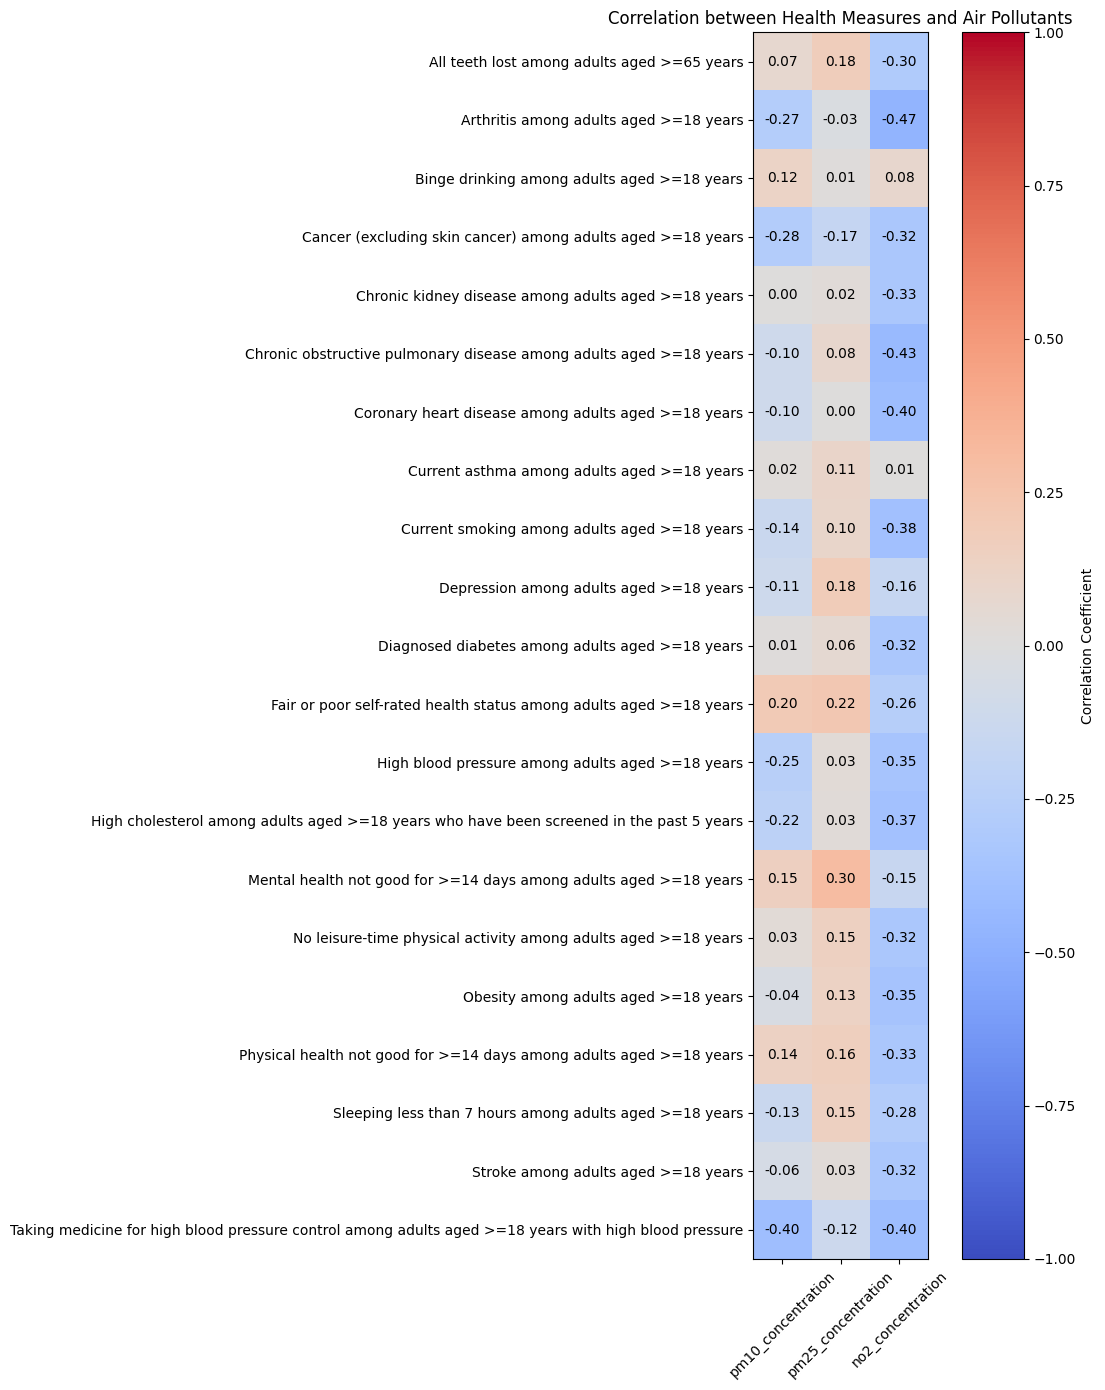

In [7]:
# Print all column names to identify the correct ones
print("Merged dataframe columns:", merged_df.columns.tolist())

# Update these with the ACTUAL column names from your print output
pollutants = ['pm10_concentration', 'pm25_concentration', 'no2_concentration']  # Use the correct names

# Get disease columns
disease_columns = [col for col in new_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
correlation_matrix = merged_df[pollutants + disease_columns].corr()

# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]

# Display the correlation matrix
print("Correlation between health measures and air pollutants:")
disease_pollutant_corr

# Visualize the correlation matrix as a heatmap using matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 14))  # Adjusted for more rows than columns
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Health Measures and Air Pollutants')
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=45)
plt.yticks(np.arange(len(disease_columns)), disease_columns)

# Add correlation values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        text = plt.text(j, i, f'{disease_pollutant_corr.iloc[i, j]:.2f}', ha="center", va="center", color="black")

plt.tight_layout()
plt.savefig('corr.png')
plt.show()